In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap

In [2]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


# Data Cleaning & Preprocessing

In [5]:
#the total number of duplicate rows
df.duplicated().sum()

np.int64(0)

# Feauter Engineering

In [6]:
df["TotalCharges"] = pd.to_numeric(
    df["TotalCharges"],
    errors="coerce"
)
df.loc[df["tenure"] == 0, "TotalCharges"] = 0


* Spend behavior features

In [7]:
df["avg_monthly_spend"] = df["TotalCharges"] / (df["tenure"] + 1)

* Tenure grouping (captures lifecycle)

In [8]:
df["tenure_group"] = pd.cut(
    df["tenure"],
    bins=[-1, 12, 24, 48, 72],
    labels=["0-1y", "1-2y", "2-4y", "4-6y"]
)

* Contract commitment strength

In [9]:
df["long_contract"] = df["Contract"].isin(
    ["One year", "Two year"]
).astype(int)


* count servicesto see higher switching cost

In [10]:
service_cols = [
    "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies"
]

df["num_services"] = df[service_cols].apply(
    lambda x: (x == "Yes").sum(),
    axis=1
)


* Checking the Payment risk indicator




In [11]:
df["auto_payment"] = df["PaymentMethod"].str.contains(
    "automatic", case=False
).astype(int)


* Automatic payment flag

In [12]:
df["auto_payment"] = df["PaymentMethod"].str.contains(
    "automatic", case=False
).astype(int)

* Electronic check risk

In [13]:
df["electronic_check"] = (df["PaymentMethod"] == "Electronic check").astype(int)

* Streaming bundle indicator

In [14]:
df["has_streaming"] = (
    (df["StreamingTV"] == "Yes") |
    (df["StreamingMovies"] == "Yes")
).astype(int)

* Security / support protection

In [15]:
df["has_protection"] = (
    (df["OnlineSecurity"] == "Yes") |
    (df["TechSupport"] == "Yes")
).astype(int)

* Relative price index

In [16]:
df["price_vs_median"] = (
    df["MonthlyCharges"] /
    df["MonthlyCharges"].median()
)

* Family responsibility proxy

In [17]:

df["family_customer"] = (
    (df["Partner"] == "Yes") |
    (df["Dependents"] == "Yes")
).astype(int)

* Senior customer risk

In [18]:
df["is_month_to_month"] = (df["Contract"] == "Month-to-month").astype(int)

df["senior_risk"] = (
    (df["SeniorCitizen"] == 1) &
    (df["is_month_to_month"] == 1)
).astype(int)

* Tenure × MonthlyCharges


In [19]:
df["tenure_charge_interaction"] = (
    df["tenure"] * df["MonthlyCharges"]
)

* Services per dollar

In [20]:

df["services_per_dollar"] = (
    df["num_services"] / (df["MonthlyCharges"] + 1)
)

# Encode data

In [21]:
# Target value
df["Churn"] = (df["Churn"] == "Yes").astype(int)

In [22]:
#Internet service type
internet_map = {"No": 0, "DSL": 1, "Fiber optic": 2}
df["internet_type"] = df["InternetService"].map(internet_map)

# EDA

 * Churn distribution

In [23]:
df["Churn"].value_counts(normalize=True) * 100

,proportion
Churn,
0,73.463013
1,26.536987


* Feature Distributions

array([[<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'MonthlyCharges'}>],
       [<Axes: title={'center': 'TotalCharges'}>,
        <Axes: title={'center': 'avg_monthly_spend'}>],
       [<Axes: title={'center': 'num_services'}>, <Axes: >]], dtype=object)

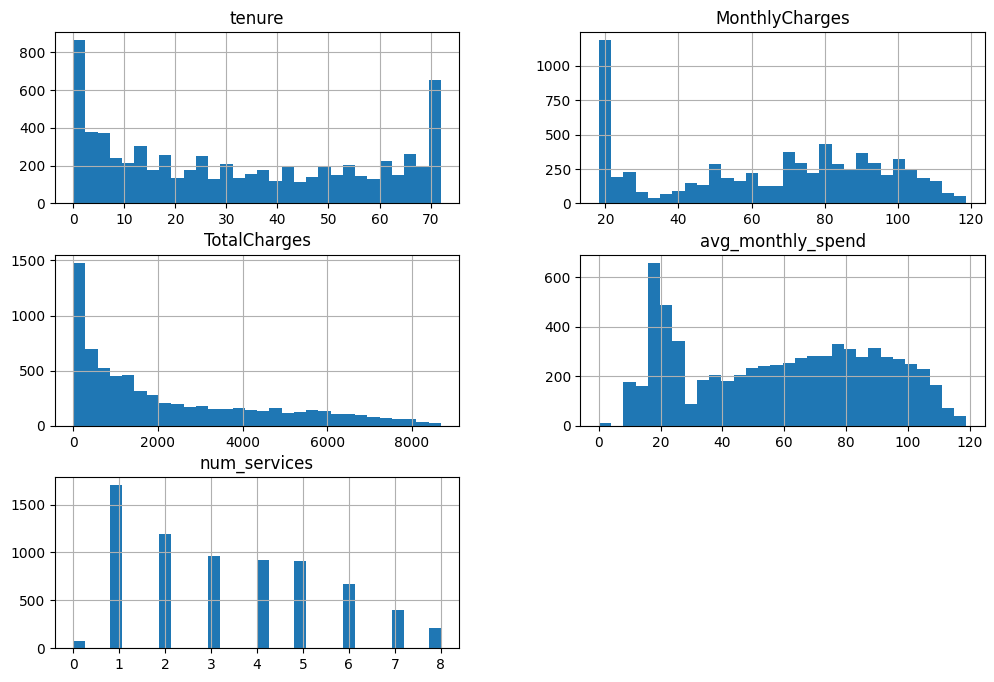

In [24]:
num_cols = [
    "tenure", "MonthlyCharges", "TotalCharges",
    "avg_monthly_spend", "num_services"
]

df[num_cols].hist(bins=30, figsize=(12,8))

In [25]:
cat_cols = [
    "Contract", "InternetService",
    "PaymentMethod", "tenure_group"
]

for col in cat_cols:
    display(df[col].value_counts(normalize=True))


,proportion
Contract,
Month-to-month,0.550192
Two year,0.240664
One year,0.209144


,proportion
InternetService,
Fiber optic,0.439585
DSL,0.343746
No,0.216669


,proportion
PaymentMethod,
Electronic check,0.335794
Mailed check,0.228880
Bank transfer (automatic),0.219225
Credit card (automatic),0.216101


,proportion
tenure_group,
4-6y,0.317904
0-1y,0.310379
2-4y,0.226324
1-2y,0.145393


* Relation Between churners & tenure





<Axes: xlabel='Churn', ylabel='tenure'>

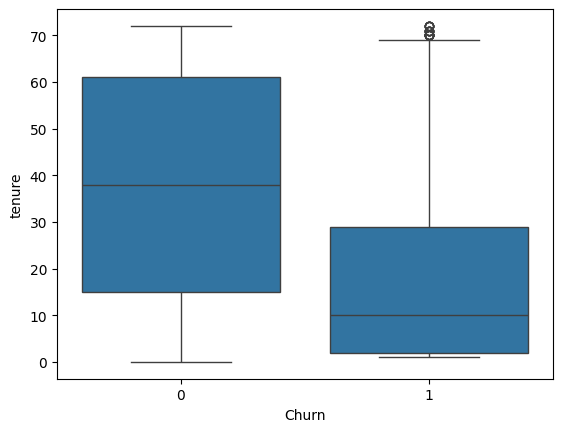

In [26]:
sns.boxplot(x="Churn", y="tenure", data=df)

* Checking if there is a danger zone tenure vs. MonthlyCharges

* Churn vs MonthlyCharges

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

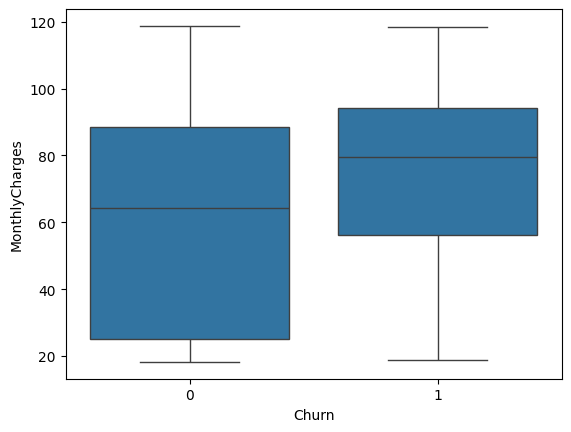

In [27]:
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)

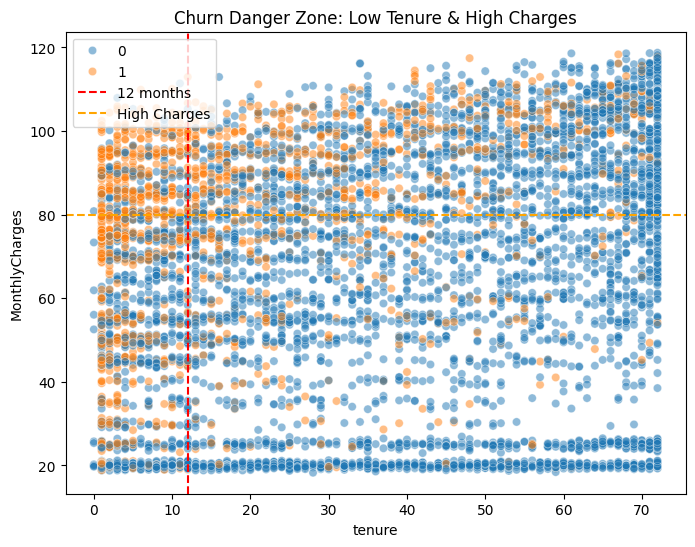

In [28]:
plt.figure(figsize=(8,6))

sns.scatterplot(
    data=df,
    x="tenure",
    y="MonthlyCharges",
    hue="Churn",
    alpha=0.5
)

plt.axvline(12, color="red", linestyle="--", label="12 months")
plt.axhline(80, color="orange", linestyle="--", label="High Charges")

plt.title("Churn Danger Zone: Low Tenure & High Charges")
plt.legend()
plt.show()


* Churn rate by contract type

In [29]:
pd.crosstab(
    df["Contract"], df["Churn"],
    normalize="index"
)

Churn,0,1
Contract,,
Month-to-month,0.572903,0.427097
One year,0.887305,0.112695
Two year,0.971681,0.028319


* Churn vs senior_risk

In [30]:
pd.crosstab(
    df["senior_risk"], df["Churn"],
    normalize="index"
)

Churn,0,1
senior_risk,,
0,0.771007,0.228993
1,0.453532,0.546468


* Churn rate by payment method

In [31]:
pd.crosstab(
    df["PaymentMethod"], df["Churn"],
    normalize="index"
).sort_values(by=1, ascending=False)


Churn,0,1
PaymentMethod,,
Electronic check,0.547146,0.452854
Mailed check,0.808933,0.191067
Bank transfer (automatic),0.832902,0.167098
Credit card (automatic),0.847569,0.152431


* Checking churn does decrease as the number of services increases.

<Axes: xlabel='Churn', ylabel='num_services'>

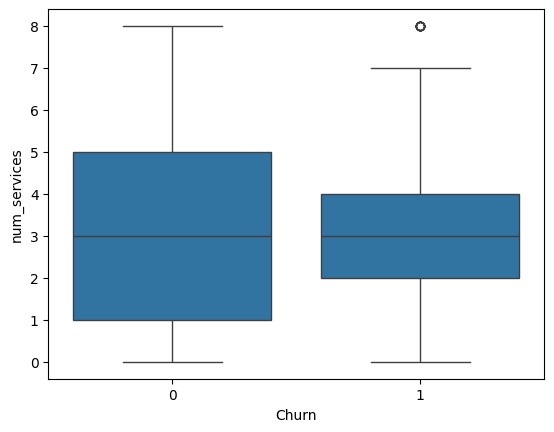

In [32]:
sns.boxplot(x="Churn", y="num_services", data=df)

* Checking does Auto-pay customers churn significantly less

In [33]:
pd.crosstab(
    df["auto_payment"], df["Churn"],
    normalize="index"
)

Churn,0,1
auto_payment,,
0,0.653256,0.346744
1,0.840183,0.159817


In [34]:
pd.crosstab(
    df["senior_risk"], df["Churn"],
    normalize="index"
)

Churn,0,1
senior_risk,,
0,0.771007,0.228993
1,0.453532,0.546468


* Seeing the COrrelations between features

<Axes: >

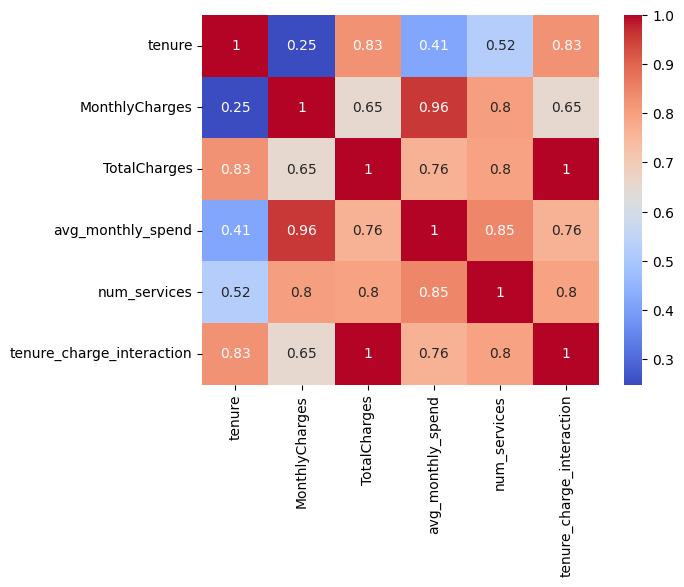

In [35]:
num_features = [
    "tenure", "MonthlyCharges", "TotalCharges",
    "avg_monthly_spend", "num_services",
    "tenure_charge_interaction"
]

sns.heatmap(
    df[num_features].corr(),
    annot=True, cmap="coolwarm"
)


# Building Prediction Modeling

In [36]:
X = df.drop(["Churn", "customerID"], axis=1, errors="ignore")
y = df["Churn"]
# Encoding the object features
X = pd.get_dummies(X, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

* Evaluate the Model

In [37]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

ROC-AUC: 0.8432237980831332


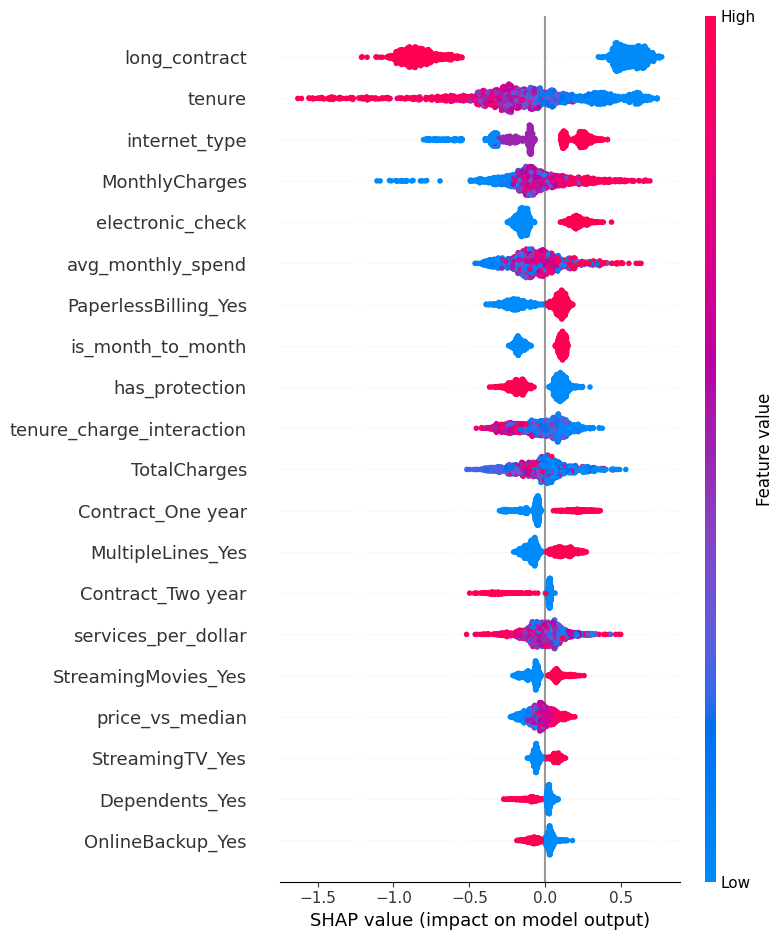

In [38]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [39]:
#Predict churn probability for all customers
df["churn_probability"] = xgb_model.predict_proba(X)[:, 1]

In [40]:
#Flag high-risk customers
high_risk_customers = df[df["churn_probability"] > 0.7]

In [41]:
high_risk_customers

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,has_streaming,has_protection,price_vs_median,family_customer,is_month_to_month,senior_risk,tenure_charge_interaction,services_per_dollar,internet_type,churn_probability
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,1,0,1.416489,0,1,0,797.20,0.049677,2,0.930046
20,8779-QRDMV,Male,1,No,No,1,No,No phone service,DSL,No,...,1,0,0.563611,0,1,1,39.65,0.049200,1,0.892985
31,4929-XIHVW,Male,1,Yes,No,2,Yes,No,Fiber optic,No,...,1,0,1.357498,1,1,1,191.00,0.041451,2,0.739870
39,8168-UQWWF,Female,0,No,No,11,Yes,Yes,Fiber optic,No,...,1,0,1.390903,0,1,0,1076.35,0.050582,2,0.922843
53,7495-OOKFY,Female,1,Yes,No,8,Yes,Yes,Fiber optic,No,...,0,0,1.146411,1,1,1,645.20,0.036742,2,0.711793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7008,1980-KXVPM,Female,1,No,No,3,Yes,Yes,Fiber optic,No,...,0,0,1.066809,0,1,1,225.15,0.026298,2,0.708271
7010,0723-DRCLG,Female,1,Yes,No,1,Yes,Yes,Fiber optic,No,...,0,0,1.058280,1,1,1,74.45,0.026508,2,0.888822
7018,1122-JWTJW,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,...,0,0,1.004264,1,1,0,70.65,0.013957,2,0.770624
7032,6894-LFHLY,Male,1,No,No,1,Yes,Yes,Fiber optic,No,...,0,0,1.076759,0,1,1,75.75,0.026059,2,0.936639
